El dataset a usar es el extraído de los experimentos realizados en [este paper](https://repositorium.sdum.uminho.pt/bitstream/1822/39169/1/main.pdf) sobre la predicción de popularidad de artículos en el sitio [Mashable](https://mashable.com/). El dataset fue preprocesado por la catedra para agregar el texto de la nota y crear los features `surprise1` y `surprise2` y el target binario `popular` en base al percentil 80% del campo `shares` (`shares` está solo para entender el dataset, logicamente no puede usarse para predecir, pero si para análisis exploratorio). El objetivo del TP es explicar y predecir la variable `popular` que vale True si la noticia es popular y False si no lo es.

# Parte III - Machine Learning - RandomForest

### Consigna

Entrenar 2 (de tipos distintos, excluyendo regresiones logísticas) modelos (5 puntos cada uno) con búsqueda de hiperparametros (¿cómo conviene elegir los datos de validación respecto de los de train?). Los modelos deben cumplir las siguientes condiciones:

* Deben utilizar AUC-ROC como métrica de validación.
* Deben medirse solo en validación, no contra test!!!
* Deben ser reproducibles (correr el notebook varias veces no afecta al resultado).
* Deben tener un score en validación superior a 0,7.
* Para el feature engineering debe utilizarse imputación de nulos, mean encoding y one hot encoding al menos una vez cada uno.
* Deben utilizar al menos 40 features (contando cómo features columnas con números, pueden venir varios de la misma variable).
* Deben utilizar CountVectorizer o TfIdfVectorizer para algunos features.
* Deberán contestar la siguiente pregunta: Para el mejor modelo de ambos, ¿cuál es el score en test? (guardar el csv con predicciones para entregarlo después)

### Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

!pip install scikit-plot
import scikitplot as skplt
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Análisis del dataset y división de train y test

In [ ]:
df  = pd.read_parquet('/content/drive/MyDrive/Datos/TP3/train')
df

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,content,surprise1,surprise2,popular,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,-0.200000,0.500000,-0.187500,0.000000,0.187500,\nHaving trouble finding something to watch on...,the world,"amusement,disgust",False,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,-0.100000,0.000000,0.000000,0.500000,0.000000,\nThe Associated Press is the latest news orga...,business,,False,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,-0.133333,0.000000,0.000000,0.500000,0.000000,\nIt looks like 2012 was a pretty good year fo...,the world,,False,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,-0.166667,0.000000,0.000000,0.500000,0.000000,"\nWhen it comes to college football, NASA astr...",sports,,False,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,-0.050000,0.454545,0.136364,0.045455,0.136364,\nLAS VEGAS -- Sharing photos and videos on yo...,the world,,False,505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35658,http://mashable.com/2014/10/28/cree-led-light-...,72.0,12.0,323.0,0.573668,1.0,0.729282,4.0,1.0,0.0,...,-0.155556,0.288889,-0.155556,0.211111,0.155556,\nLED lighting is more power-efficient and las...,science/tech,,True,42000
35659,http://mashable.com/2014/10/28/dancing-with-th...,72.0,13.0,433.0,0.563084,1.0,0.756654,3.0,2.0,9.0,...,-0.166667,0.833333,0.500000,0.333333,0.500000,"\nWith only eight couples left, ABC had to fin...",the world,,False,2300
35660,http://mashable.com/2014/10/28/dangerous-airpo...,72.0,13.0,1061.0,0.498020,1.0,0.686688,5.0,5.0,1.0,...,-0.050000,0.400000,-0.400000,0.100000,0.400000,\nParo Airport in Bhutan is located in a deep ...,the world,"disgust,optimism",False,567
35661,http://mashable.com/2014/10/28/disney-villains...,72.0,13.0,1777.0,0.449708,1.0,0.631970,36.0,28.0,12.0,...,-0.100000,0.000000,0.000000,0.500000,0.000000,"\nDisney villains are evil, but no one tops th...",the world,"love,optimism",False,783


In [ ]:
df.columns

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
     

Tomo el 90% de las filas para entrenar y el otro 10% para validar. Para evitar el time-travelling y como los datos estan ordenados segun timedelta, tomo los primeros registros para entrenar y los restantes para validar, en lugar de tomar registros random:

In [ ]:
train = df.head(int(len(df)*0.9)).copy()
valid = df.tail(int(len(df)*0.1)).copy()

In [ ]:
train.head(6)

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,content,surprise1,surprise2,popular,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,-0.200000,0.500000,-0.187500,0.000000,0.187500,\nHaving trouble finding something to watch on...,the world,"amusement,disgust",False,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,-0.100000,0.000000,0.000000,0.500000,0.000000,\nThe Associated Press is the latest news orga...,business,,False,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,-0.133333,0.000000,0.000000,0.500000,0.000000,\nIt looks like 2012 was a pretty good year fo...,the world,,False,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,-0.166667,0.000000,0.000000,0.500000,0.000000,"\nWhen it comes to college football, NASA astr...",sports,,False,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,-0.050000,0.454545,0.136364,0.045455,0.136364,\nLAS VEGAS -- Sharing photos and videos on yo...,the world,,False,505
5,http://mashable.com/2013/01/07/beewi-smart-toys/,731.0,10.0,370.0,0.559889,1.0,0.698198,2.0,2.0,0.0,...,-0.100000,0.642857,0.214286,0.142857,0.214286,\nLAS VEGAS -- RC toys have traded in their bu...,science/tech,,False,855


### Encoding

Quito los features url, timedelta y shares:

In [ ]:
features = ['n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'rate_positive_words',
       'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity',
       'max_positive_polarity', 'avg_negative_polarity',
       'min_negative_polarity', 'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'abs_title_sentiment_polarity', 'content', 'surprise1', 'surprise2',
       'popular']

In [ ]:
train = train.loc[:, features]
valid = valid.loc[:, features]

Para los valores numéricos del dataset reemplazo los nans con la media de la columna:

In [ ]:
means = {}

def fill_numeric_na(data):
  for column in data:
    if data[column].dtype == np.float64:
      if column not in means:
        mean =  data[column].sum()/len(data[column])
        means[column] = mean
      data[column].fillna(means[column], inplace=True)
  
fill_numeric_na(train)
fill_numeric_na(valid)

Encodeo content utilizando CountVectorizer:

In [ ]:
vectorizer = CountVectorizer(lowercase=True, stop_words='english', max_features=30)
train['content'].fillna('', inplace=True)
transformation = vectorizer.fit_transform(train['content'])
feature_names = vectorizer.get_feature_names_out()

count_vect_df = pd.DataFrame(transformation.todense(), columns=feature_names)
train = pd.concat([train, count_vect_df], axis=1)
train.drop('content', axis=1, inplace=True)
train.head(6)

,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,...,time,twitter,use,users,video,way,work,world,year,years
0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,0.0,4.680365,...,0,0,0,2,3,0,0,0,1,0
1,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,0.0,4.913725,...,2,5,0,1,0,2,0,0,0,0
2,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,0.0,4.393365,...,1,0,0,0,0,0,0,1,2,0
3,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,0.0,4.404896,...,2,0,0,0,0,4,0,0,0,0
4,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,0.0,4.682836,...,0,0,1,0,3,0,1,0,0,0
5,10.0,370.0,0.559889,1.0,0.698198,2.0,2.0,0.0,0.0,4.359459,...,0,0,1,0,1,0,0,0,1,0


In [ ]:
valid['content'].fillna('', inplace = True)
transformation = vectorizer.transform(valid['content'])
valid.reset_index(inplace=True, drop=True)
count_vect_df = pd.DataFrame(transformation.todense(), columns=feature_names)
valid = pd.concat([valid, count_vect_df], axis=1)
valid.drop('content', axis=1, inplace=True)

Aplico One Hot Encoding a surprise1:

In [ ]:
surprise1_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
encoded_sur1 = surprise1_encoder.fit_transform(train[['surprise1']]).todense().astype(int)
train = train.reset_index().drop(['index', 'surprise1'], axis=1).join(pd.DataFrame(encoded_sur1, columns=surprise1_encoder.get_feature_names_out()))
encoded_sur1 = surprise1_encoder.transform(valid[['surprise1']]).todense().astype(int)
valid = valid.reset_index().drop(['index', 'surprise1'], axis=1).join(pd.DataFrame(encoded_sur1, columns=surprise1_encoder.get_feature_names_out()))

Aplico Mean Encoding a surprise2:



In [ ]:
value_counts = train['surprise2'].value_counts()
y = value_counts[value_counts < 20].index
train['surprise2'] = train['surprise2'].replace({x:'other' for x in y})

surprise2_means = train.groupby(['surprise2'])['popular'].mean().to_dict()
train['surprise2'] = train['surprise2'].map(surprise2_means)

In [ ]:
valid['surprise2'] = valid['surprise2'].map(lambda x: surprise2_means.get(x, surprise2_means['other']))

Separo el target del resto del dataset:

In [ ]:
y_train = train.popular
x_train = train.drop('popular', axis=1)

y_valid = valid.popular
x_valid = valid.drop('popular', axis=1)

In [ ]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3566 entries, 0 to 3565
Data columns (total 93 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   n_tokens_title                 3566 non-null   float64
 1   n_tokens_content               3566 non-null   float64
 2   n_unique_tokens                3566 non-null   float64
 3   n_non_stop_words               3566 non-null   float64
 4   n_non_stop_unique_tokens       3566 non-null   float64
 5   num_hrefs                      3566 non-null   float64
 6   num_self_hrefs                 3566 non-null   float64
 7   num_imgs                       3566 non-null   float64
 8   num_videos                     3566 non-null   float64
 9   average_token_length           3566 non-null   float64
 10  num_keywords                   3566 non-null   float64
 11  data_channel_is_lifestyle      3566 non-null   float64
 12  data_channel_is_entertainment  3566 non-null   f

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32096 entries, 0 to 32095
Data columns (total 93 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   n_tokens_title                 32096 non-null  float64
 1   n_tokens_content               32096 non-null  float64
 2   n_unique_tokens                32096 non-null  float64
 3   n_non_stop_words               32096 non-null  float64
 4   n_non_stop_unique_tokens       32096 non-null  float64
 5   num_hrefs                      32096 non-null  float64
 6   num_self_hrefs                 32096 non-null  float64
 7   num_imgs                       32096 non-null  float64
 8   num_videos                     32096 non-null  float64
 9   average_token_length           32096 non-null  float64
 10  num_keywords                   32096 non-null  float64
 11  data_channel_is_lifestyle      32096 non-null  float64
 12  data_channel_is_entertainment  32096 non-null 

In [ ]:
x_train.columns == x_valid.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

### Búsqueda de hiperparámetros y entrenamiento del modelo

In [ ]:
random_forest = RandomForestClassifier()
hiper_params = {'n_estimators': [10, 20, 50, 70, 75, 80, 100],
                'max_depth': [10, 15, 20, 25, 30, 35, 40, 45, 50],
                'min_samples_split': [2, 4, 5, 6, 10],
                'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                'max_features': [30, 35, 40, 50, 60],
                'bootstrap': [True, False]}
model = RandomizedSearchCV(random_forest, hiper_params, n_iter=50, verbose=100, scoring='roc_auc',  random_state=123)
model.fit(x_train.values, y_train.values)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5; 1/50] START bootstrap=False, max_depth=35, max_features=60, min_samples_leaf=6, min_samples_split=4, n_estimators=70
[CV 1/5; 1/50] END bootstrap=False, max_depth=35, max_features=60, min_samples_leaf=6, min_samples_split=4, n_estimators=70;, score=0.621 total time= 1.3min
[CV 2/5; 1/50] START bootstrap=False, max_depth=35, max_features=60, min_samples_leaf=6, min_samples_split=4, n_estimators=70
[CV 2/5; 1/50] END bootstrap=False, max_depth=35, max_features=60, min_samples_leaf=6, min_samples_split=4, n_estimators=70;, score=0.685 total time= 1.3min
[CV 3/5; 1/50] START bootstrap=False, max_depth=35, max_features=60, min_samples_leaf=6, min_samples_split=4, n_estimators=70
[CV 3/5; 1/50] END bootstrap=False, max_depth=35, max_features=60, min_samples_leaf=6, min_samples_split=4, n_estimators=70;, score=0.674 total time= 1.3min
[CV 4/5; 1/50] START bootstrap=False, max_depth=35, max_features=60, min_samples_leaf=6, 

RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 15, 20, 25, 30, 35,
                                                      40, 45, 50],
                                        'max_features': [30, 35, 40, 50, 60],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                                        'min_samples_split': [2, 4, 5, 6, 10],
                                        'n_estimators': [10, 20, 50, 70, 75, 80,
                                                         100]},
                   random_state=123, scoring='roc_auc', verbose=100)

### Predicción para validation

In [ ]:
binary_preds = model.predict(x_valid.values)
proba_preds = model.predict_proba(x_valid.values)[:, 1]

In [ ]:
print(classification_report(y_valid.values, binary_preds))

              precision    recall  f1-score   support

       False       0.83      1.00      0.91      2942
        True       0.68      0.02      0.05       624

    accuracy                           0.83      3566
   macro avg       0.75      0.51      0.48      3566
weighted avg       0.80      0.83      0.75      3566



In [ ]:
roc_auc_score(y_valid.values, proba_preds)

0.7367578744618175

El mejor score obtenido para validation fue 0.7367578744618175.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


<Figure size 900x600 with 0 Axes>

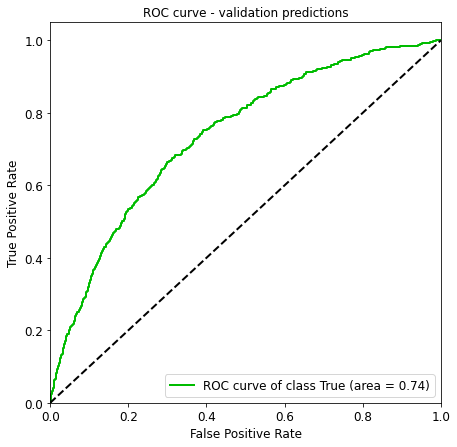

In [ ]:
plt.figure(dpi=150)
skplt.metrics.plot_roc(y_valid.values, model.predict_proba(x_valid), classes_to_plot=1, plot_micro=False, plot_macro=False, figsize=(7,7),\
                       title_fontsize="large", text_fontsize="large")
plt.title('ROC curve - validation predictions')
plt.show()